# PyTorch NN Module

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

def _print(val):
    print(val, val.shape, '\n')

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [4]:
x_train.shape

(50000, 784)

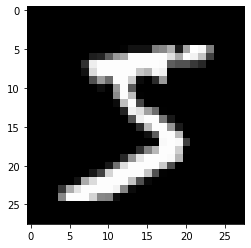

In [13]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x_train[0].reshape(-1,28,28).squeeze(), cmap='gray')


In [15]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, 
                                       (x_train, y_train, x_valid, y_valid))
print(x_train.shape)
print(y_train, y_train.min(), y_train.max())

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([50000, 784])
tensor([5, 0, 4,  ..., 8, 4, 8]) tensor(0) tensor(9)


## Neural Nets from Scratch

### Activation log_softmax

LogSoftMax works better than regular SoftMax? [link](https://discuss.pytorch.org/t/logsoftmax-vs-softmax/21386/2)

The point is, even though logsoftmax and softmax are monotonic, their effect on the relative values of the loss function changes. Using the log-softmax will punish bigger mistakes in likelihood space higher.

In [18]:
import math

#Activation function Outputs log-probabilities
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb.mm(weights) + bias)



#Xavier Initialization
weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10)
bias.requires_grad_()

print(x_train.shape)
print(weights.shape)
print(bias.shape)

torch.Size([50000, 784])
torch.Size([784, 10])
torch.Size([10])


In [111]:
xb = x_train[:3]
yb = y_train[:3]
print(xb.shape)
print(xb.mm(weights).shape,'\n')
print(xb.mm(weights)[0],'\n')
print(xb.mm(weights)[0]+bias,'\n')
xb = xb.mm(weights)+bias
print(xb.exp().sum(-1).log().unsqueeze(-1),'\n')
print((xb - xb.exp().sum(-1).log().unsqueeze(-1))[0])
pred = xb - xb.exp().sum(-1).log().unsqueeze(-1)
print(torch.argmax(pred, 1))
print(yb)

torch.Size([3, 784])
torch.Size([3, 10]) 

tensor([ 0.8506, -4.5983,  0.6762,  4.9477, -6.0592,  4.6678, -1.0155,  0.1793,
         1.5168, -0.6079], grad_fn=<SelectBackward>) 

tensor([ 0.5322, -4.2668,  0.7402,  4.7284, -6.0082,  5.7624, -1.0864,  0.7272,
         0.2620, -0.8336], grad_fn=<AddBackward0>) 

tensor([[ 6.0849],
        [11.4318],
        [ 4.9742]], grad_fn=<UnsqueezeBackward0>) 

tensor([ -5.5527, -10.3517,  -5.3447,  -1.3565, -12.0931,  -0.3225,  -7.1713,
         -5.3577,  -5.8229,  -6.9185], grad_fn=<SelectBackward>)
tensor([5, 0, 4])
tensor([5, 0, 4])


### Negative log loss

Log loss (related to cross entropy mesures performance of classification where prediction input is a prob value between 0 and 1. Perfect model should have log loss 0. 

Log loss increases as predicted prob diverges from actual label.

<img src=http://wiki.fast.ai/images/math/8/a/a/8aa1e513366a2046bee816f7a0f8dd1c.png>

Note that y=0 if incorrect class

Since the activation function was log_softmax, we dot have to take the log of the activation again. Just take the negative activation of the True class for each example

In [30]:
def nll(input, target):
    return -input[range(target.shape[0]),target].mean()

def accuracy(input, target):
    p = torch.argmax(input, dim=1)
    return (p==target).float().mean()

yb = y_train[:batch_size]
print(accuracy(pred,yb))
print(nll(preds,yb))

tensor(0.0469)
tensor(2.4654, grad_fn=<NegBackward>)


In [103]:
print(-pred[0].max())
# grab the log-prob of correct class
print(-pred[range(yb.shape[0]),yb])
#this is neg_log_loss for each example -> 
#average them for cost
print(-pred[range(yb.shape[0]),yb].mean())
#want to maximize this number -> make correct class as
#large as possible

#How does this work? seems like signs are wrong

tensor(0.3225, grad_fn=<NegBackward>)
tensor([0.3225, 0.0006, 0.1621], grad_fn=<NegBackward>)
tensor(0.1617, grad_fn=<NegBackward>)


### Training the parameters

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).



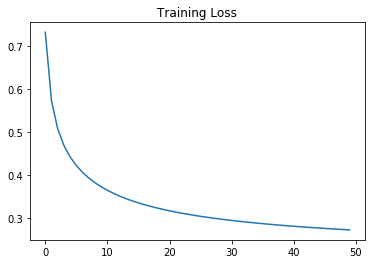

In [51]:
from IPython.core.debugger import set_trace

#Xavier Initialization
weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10)
bias.requires_grad_()


epochs = 50 # each epoch goes over the entire training set
batch_size = 64
lr = 0.01
n = x_train.shape[0]

loss_hist = []
for epoch in range(epochs):
    for i in range((n-1)//batch_size): # // ~ int division
        start = i * batch_size
        end = (i + 1) * batch_size

        xb, yb = x_train[start:end], y_train[start:end]
        pred = model(xb)
        loss = nll(pred, yb)
        loss.backward()

        with torch.no_grad(): #no_grad so we can do an in-place operation on a leaf node
            weights -= lr*weights.grad
            bias -= lr*bias.grad
            weights.grad.zero_()
            bias.grad.zero_()
    loss_hist.append(loss.data.item())

plt.title("Training Loss")
plt.plot(range(len(loss_hist)),loss_hist) 
plt.show()

In [52]:
pred = model(x_valid)
print(nll(pred, y_valid))
print(accuracy(pred, y_valid))

tensor(0.2794, grad_fn=<NegBackward>)
tensor(0.9224)


## Factoring with torch.nn
Either make your code shorter, more understandable, or more flexible.

In [ ]:
import torch.nn.functional as F

#combines neg-log-likelihood loss and log-softmax
loss_func = F.cross_entropy
def model(xb):
    return xb.mm(weights)+bias

### Package the model into a Class
Use nn.Module and nn.Parameter . Create a class that holds weights and methords for forward and backward prop.

nn.Module has a number of attributes and methods (such as .parameters() and .zero_grad()) which we will be using.

In [104]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        return None
        
    def forward(self, xb):
        return xb.mm(self.weights) + self.bias

### Train with model.parameters() and model.zero_grad()

In [115]:
for param in model.parameters():
        print(param)

Parameter containing:
tensor([[ 0.0077, -0.0490, -0.0650,  ..., -0.0799, -0.0376,  0.0465],
        [ 0.0032,  0.0115,  0.0170,  ...,  0.0832, -0.0065,  0.0299],
        [ 0.0209, -0.0426,  0.0061,  ...,  0.0147,  0.0168, -0.0500],
        ...,
        [ 0.0304, -0.0111,  0.0396,  ..., -0.0030,  0.0064,  0.0461],
        [ 0.0436,  0.0159, -0.0118,  ...,  0.0390, -0.0258, -0.0533],
        [-0.1070, -0.0257, -0.0111,  ...,  0.0088,  0.0612, -0.0377]],
       requires_grad=True)
Parameter containing:
tensor([-0.3168,  0.3398,  0.0577, -0.2241,  0.0583,  1.0992, -0.0698,  0.5458,
        -1.2579, -0.2323], requires_grad=True)


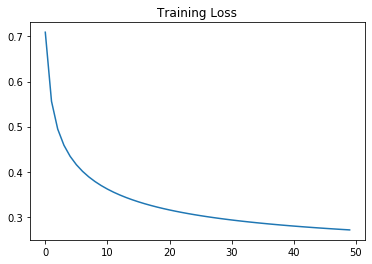

In [109]:
model = Model()
loss_func = F.cross_entropy

def fit():
    loss_hist = []
    for epoch in range(epochs):
        for i in range((n-1)//batch_size): # // ~ int division
            start = i * batch_size
            end = (i + 1) * batch_size

            xb, yb = x_train[start:end], y_train[start:end]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): #Update all weights at once
                    p -= lr*p.grad
                model.zero_grad()   #zero out gradients for all parameters
        loss_hist.append(loss.data.item())
        
    return loss_hist
    
loss_hist = fit()

plt.title("Training Loss")
plt.plot(range(len(loss_hist)),loss_hist) 
plt.show()

### With nn.Linear
[link](https://pytorch.org/tutorials/beginner/nn_tutorial.html#refactor-using-nn-linear)

## Models in PyTorch
Model can be definde by subclassing the torch.nn.Module class. Define the parameters, then define the forward propagation of inputs.

In [ ]:
class myNetwork(nn.Module):
    def __init(self):
        super(myNetwork, self).__init__()
        self.linear1 = nn.Linear(D_in, H_out)
        self.linear2 = nn.Linear(H_out, D_out)
    def forward(self, data):
        out = F.relu(self.linear1(data))
        out = self.linear2(out)
        return out

## Saving and Loading Modules

In [ ]:
state = {
    'epoch':epoch+1
    'state_dict':model.state_dict()
    'optim_dict':optimider.state_dict()
}
utils.save_checkpoint(state,
                     isbest=True,
                     checkpoint='filepath')
utils.load_checkpoint(restore_path, 
                      model, 
                      optimizer)

# Functions

### Convolutions

In [8]:
m = nn.Conv2d(16,33,(3,5), 
              stride=(2,1), 
              padding = (4,2), 
              dilation=(3,1))
input = Variable(torch.randn(20,16,50,100))
print(input.shape)
m(input).shape

torch.Size([20, 16, 50, 100])


torch.Size([20, 33, 26, 100])

### Pooling

In [28]:
"""
Max Pooling - cuts the size in have by retaining only the max 
value in a subset of a matrix. Outputs a smaller matrix with
the combined max values for the subcells.

Reduces the number of parameters to learn and provides basic 
 translation invariance to the internal representation.
"""
m = nn.MaxPool2d((2,2))
x = torch.arange(16, dtype = torch.float64).reshape(-1,4).unsqueeze(0)
pooled= m(x)
_print(x)
_print(pooled)

tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]]], dtype=torch.float64) torch.Size([1, 4, 4]) 

tensor([[[ 5.,  7.],
         [13., 15.]]], dtype=torch.float64) torch.Size([1, 2, 2]) 



In [29]:
m = nn.AvgPool2d(2)
_print(m(x))

tensor([[[ 2.5000,  4.5000],
         [10.5000, 12.5000]]], dtype=torch.float64) torch.Size([1, 2, 2]) 



## Non-Linear Activation

In [40]:
x = Variable(torch.randn(3,3))
_print(x)

tensor([[-0.6745,  0.9691,  1.0134],
        [-0.3971,  0.3070, -0.0195],
        [ 0.0943, -0.8966,  0.7574]]) torch.Size([3, 3]) 



In [41]:
m = nn.ReLU()
_print(m(x))

tensor([[0.0000, 0.9691, 1.0134],
        [0.0000, 0.3070, 0.0000],
        [0.0943, 0.0000, 0.7574]]) torch.Size([3, 3]) 



In [42]:
m = nn.LeakyReLU()
_print(m(x))

tensor([[-6.7450e-03,  9.6910e-01,  1.0134e+00],
        [-3.9710e-03,  3.0700e-01, -1.9512e-04],
        [ 9.4303e-02, -8.9660e-03,  7.5740e-01]]) torch.Size([3, 3]) 



In [43]:
m = nn.Sigmoid()
_print(m(x))

tensor([[0.3375, 0.7249, 0.7337],
        [0.4020, 0.5762, 0.4951],
        [0.5236, 0.2897, 0.6808]]) torch.Size([3, 3]) 



In [48]:
m = nn.Softmax(dim=0)
_print(m(x))

tensor([[0.2234, 0.5986, 0.4695],
        [0.2948, 0.3087, 0.1671],
        [0.4819, 0.0927, 0.3634]]) torch.Size([3, 3]) 



## Normalization

In [ ]:
"""
nn.BatchNorm1d(
    num_features,
    eps=1e-05,
    momentum=0.1,
    affine=True,
    track_running_stats=True,
)
Docstring:     
Applies Batch Normalization over a 2D or 3D input (a mini-batch of 1D
inputs with optional additional channel dimension) as described in the paper
`Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift`_ .
"""

nn.BatchNorm1d(100)

## Recurrent Layers

In [53]:
    
"""
Applies a multi-layer Elman RNN with :math:`tanh` or :math:`ReLU` non-linearity to an
input sequence.


For each element in the input sequence, each layer computes the following
function:

.. math::
    h_t = \text{tanh}(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})

where :math:`h_t` is the hidden state at time `t`, :math:`x_t` is
the input at time `t`, and :math:`h_{(t-1)}` is the hidden state of the
previous layer at time `t-1` or the initial hidden state at time `0`.
If :attr:`nonlinearity` is ``'relu'``, then `ReLU` is used instead of `tanh`.

Args:
    input_size: The number of expected features in the input `x`
    hidden_size: The number of features in the hidden state `h`
    num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
        would mean stacking two RNNs together to form a `stacked RNN`,
        with the second RNN taking in outputs of the first RNN and
        computing the final results. Default: 1
    nonlinearity: The non-linearity to use. Can be either ``'tanh'`` or ``'relu'``. Default: ``'tanh'``
    bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
        Default: ``True``
    batch_first: If ``True``, then the input and output tensors are provided
        as `(batch, seq, feature)`. Default: ``False``
    dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
        RNN layer except the last layer, with dropout probability equal to
        :attr:`dropout`. Default: 0
    bidirectional: If ``True``, becomes a bidirectional RNN. Default: ``False``

Inputs: input, h_0
    - **input** of shape `(seq_len, batch, input_size)`: tensor containing the features
      of the input sequence. The input can also be a packed variable length
      sequence. See :func:`torch.nn.utils.rnn.pack_padded_sequence`
      or :func:`torch.nn.utils.rnn.pack_sequence`
      for details.
    - **h_0** of shape `(num_layers * num_directions, batch, hidden_size)`: tensor
      containing the initial hidden state for each element in the batch.
      Defaults to zero if not provided. If the RNN is bidirectional,
      num_directions should be 2, else it should be 1.

Outputs: output, h_n
    - **output** of shape `(seq_len, batch, num_directions * hidden_size)`: tensor
      containing the output features (`h_t`) from the last layer of the RNN,
      for each `t`.  If a :class:`torch.nn.utils.rnn.PackedSequence` has
      been given as the input, the output will also be a packed sequence.

      For the unpacked case, the directions can be separated
      using ``output.view(seq_len, batch, num_directions, hidden_size)``,
      with forward and backward being direction `0` and `1` respectively.
      Similarly, the directions can be separated in the packed case.
    - **h_n** of shape `(num_layers * num_directions, batch, hidden_size)`: tensor
      containing the hidden state for `t = seq_len`.

      Like *output*, the layers can be separated using
      ``h_n.view(num_layers, num_directions, batch, hidden_size)``.

Shape:
    - Input1: :math:`(L, N, H_{in})` tensor containing input features where
      :math:`H_{in}=\text{input\_size}` and `L` represents a sequence length.
    - Input2: :math:`(S, N, H_{out})` tensor
      containing the initial hidden state for each element in the batch.
      :math:`H_{out}=\text{hidden\_size}`
      Defaults to zero if not provided. where :math:`S=\text{num\_layers} * \text{num\_directions}`
      If the RNN is bidirectional, num_directions should be 2, else it should be 1.
    - Output1: :math:`(L, N, H_{all})` where :math:`H_{all}=\text{num\_directions} * \text{hidden\_size}`
    - Output2: :math:`(S, N, H_{out})` tensor containing the next hidden state
      for each element in the batch

Attributes:
    weight_ih_l[k]: the learnable input-hidden weights of the k-th layer,
        of shape `(hidden_size, input_size)` for `k = 0`. Otherwise, the shape is
        `(hidden_size, num_directions * hidden_size)`
    weight_hh_l[k]: the learnable hidden-hidden weights of the k-th layer,
        of shape `(hidden_size, hidden_size)`
    bias_ih_l[k]: the learnable input-hidden bias of the k-th layer,
        of shape `(hidden_size)`
    bias_hh_l[k]: the learnable hidden-hidden bias of the k-th layer,
        of shape `(hidden_size)`

.. note::
    All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
    where :math:`k = \frac{1}{\text{hidden\_size}}`

.. include:: cudnn_persistent_rnn.rst

Examples::

    >>> rnn = nn.RNN(10, 20, 2)
    >>> input = torch.randn(5, 3, 10)
    >>> h0 = torch.randn(2, 3, 20)
    >>> output, hn = rnn(input, h0)
"""
#nn.RNN(input_size, hidden_size, num_recurrent_layers, nonlinearity,)
x = Variable(torch.randn(5,3,10))
rnn = nn.RNN(10,20,2)
h0 = Variable(torch.randn(2,3,20))
out, hn = rnn(x, h0)
print(out.shape)

torch.Size([5, 3, 20])


In [52]:
lstm = nn.LSTM(10,20,2)
c0 = Variable(torch.randn(2,3,20))
out, hn = lstm(x,(h0,c0))
print(out.shape)

torch.Size([5, 3, 20])


In [55]:
gru = nn.GRU(10,20,2)
out,hnn = gru(x, h0)
print(out.shape)

torch.Size([5, 3, 20])


## Linear

In [56]:
"""
nn.Linear(in_features, out_features, bias=True)
Docstring:     
Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

Args:
    in_features: size of each input sample
    out_features: size of each output sample
"""
x = Variable(torch.randn(128,20))
m = nn.Linear(20,2)
print(m(x).shape)

torch.Size([128, 2])


## Dropout

In [72]:
#zeroes out some of the values in the input tensor
m = nn.Dropout(p=0.5)
input = Variable(torch.randn(5, 2))
output = m(input)
output

tensor([[-0.0000, -0.0000],
        [-1.4435, -0.1157],
        [ 0.0000, -2.5524],
        [ 0.0000, -0.0000],
        [ 2.6681, -1.1160]])

## Embedding

In [73]:
# the input is an integer that selects the embedding
embedding = nn.Embedding(10,3)
x = torch.tensor([[2,1,1],[3,5,2]], dtype = torch.long)
embedding(x)

tensor([[[-1.0281, -0.1043, -0.9801],
         [ 0.0454,  1.2075, -0.5769],
         [ 0.0454,  1.2075, -0.5769]],

        [[ 0.7194,  1.8701, -0.5869],
         [ 0.8274,  0.9918,  0.6741],
         [-1.0281, -0.1043, -0.9801]]], grad_fn=<EmbeddingBackward>)

## Cosine Similarity

In [75]:
input1 = Variable(torch.randn(100, 128))
input2 = Variable(torch.randn(100, 128))
cos = nn.CosineSimilarity()
print(cos(input1,input2).shape)

torch.Size([100])


## Loss Functions

In [81]:
loss = nn.L1Loss()
pred = Variable(torch.randn(1,10), requires_grad=True)
target = Variable(torch.randn(1,10))
print(loss(pred,target))

tensor(1.1297, grad_fn=<L1LossBackward>)


In [82]:
loss = nn.MSELoss()
print(loss(pred,target))

tensor(1.8602, grad_fn=<MseLossBackward>)


In [95]:
loss = nn.CrossEntropyLoss()
target = Variable(torch.LongTensor(1).random_(5))
target = Variable(torch.randint(5, (1,),dtype=torch.long))
print(loss(pred,target))

tensor(1.7376, grad_fn=<NllLossBackward>)


In [93]:
target

tensor([4])

## init

In [97]:
w = torch.empty(3,5)
nn.init.normal(w) #operates inplace

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  


tensor([[-1.1021, -2.0721, -1.0736, -0.4213,  1.4890],
        [-0.1656, -0.0502, -1.2592, -0.7588, -0.2377],
        [ 0.2969,  0.1076,  0.6622,  0.1856, -0.0085]])